In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spei as si 
import geopandas as gpd
from shapely.geometry import Point
import fiona 
from pyproj import CRS

### Import boundaries for spatial distribution

In [2]:
# Read the shapefile
shapefile_path = '//gmvstorage.gmv.es/storage/anin/South_African_secondaryCatchments/Secondary Catchment.shp'
areas = gpd.read_file(shapefile_path)

# Field in the shapefile table of attributes to be used for the averaging of the SGI in this case  "SECONDARY" for secondary catchments
grouping_field = 'SECONDARY' 

#### Parametrization to be adjusted

In [3]:
# Define the CRS in which we're going to be working 
mycrs = 'EPSG:4326'
# General output path:
path_out = "//gmvstorage.gmv.es/storage/anin/Groundwater/SGI_outputs/"

# Output directory: In this case  Secondary_catchments 
dir_out = "Secondary_catchments"

### Import stations data

In [4]:
# Import data and metadata

# Load Metadata 
metadata_path = "//gmvstorage.gmv.es/storage/anin/Groundwater/processed_data/stations_metadadata22_active.xlsx"
meta_df = pd.read_excel(metadata_path)
meta_df.set_index('Station',inplace=True)

# Select the columns that are necessary for this code
meta_df = meta_df.iloc[:, 0:2]

# Load data
df_path = "//gmvstorage.gmv.es/storage/anin/Groundwater/processed_data/stations_data22_active.xlsx"
df = pd.read_excel(df_path)
df = df.iloc[:,1:]
df.set_index('date',inplace=True)

### Compute the SGI for all the stations

In [5]:
# Import the modified sgi function which includes scaling 
from sgi_tools import compute_sgi

In [6]:
# Define groundwater index scale factor
scale = 3

# Create a new DataFrame to store the SGI values
df_sgi = pd.DataFrame()

# Apply the SGI function to each column of the DataFrame

for column in df.columns:
    df_sgi[column] = compute_sgi(df[column],scale)

# Reset the index & Transpose the DataFrame
dates = df_sgi.index.to_pydatetime()
df_sgi = df_sgi.reset_index(drop = True)
df_sgi = df_sgi.T

C:\Users\ecig\AppData\Local\Temp\ipykernel_8316\2817679859.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sgi[column] = compute_sgi(df[column],scale)
C:\Users\ecig\AppData\Local\Temp\ipykernel_8316\2817679859.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sgi[column] = compute_sgi(df[column],scale)
C:\Users\ecig\AppData\Local\Temp\ipykernel_8316\2817679859.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

#### Perform the average of the SGI values at each timestep for each catchment in the shapefile

In [7]:


# Join with coordinate information in metadata dataframe
df_latlon = df_sgi.join(meta_df)

# Convert the stations dataframe into a GeoDataFrame by specifying the geometry column with the coordinates:

geometry = [Point(xy) for xy in zip(df_latlon['Longitude'], df_latlon['Latitude'])]
stations_gdf = gpd.GeoDataFrame(df_latlon, geometry=geometry)

# Perform a spatial join between the polygons and the stations to determine which stations fall within each polygon:
stations_by_polygon = gpd.sjoin(areas, stations_gdf, how='inner', op='contains')

# Select the columns based on their numeric names
time_step_columns = [col for col in stations_by_polygon.columns if str(col).isdigit()]

# Group the stations by polygon and time step, and calculate the average for each group:
sgi_averages = stations_by_polygon.groupby([grouping_field])[time_step_columns].mean()

# Remove the time step columns from the stations_by_polygon
stations_by_polygon = stations_by_polygon.drop(columns=time_step_columns)

# Set the CRS of the GeoDataFrame
stations_by_polygon.crs = mycrs


c:\Users\ecig\Anaconda3\envs\geoTools\lib\site-packages\IPython\core\interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\ecig\AppData\Local\Temp\ipykernel_8316\4089559449.py:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  stations_by_polygon = gpd.sjoin(areas, stations_gdf, how='inner', op='contains')


### Prepare the SGI by catchments data to be exported and compared with other indices

In [8]:
# Simplify the "areas" shapefile before merging it with the SGI averages

columns_to_keep = [6, 7, 9, 10,17]  # columns to keep
areas = areas.iloc[:, columns_to_keep] # Keep only the specified columns

# Perform spatial join between areas and the SGI averages
export_sgi = areas.merge(sgi_averages, on=grouping_field, how='left')
# Set the CRS 
export_sgi.crs = mycrs


# Export as geojson
fN_geojson = f'{path_out}/{dir_out}/SGI_catchments_ts.geojson'
with open(fN_geojson, 'w') as f:
    f.write(export_sgi.to_json())

#### Export the data to be able to plot it nicely

In [9]:
# Transform stations locations into points and export as shapefile

stations_location = gpd.points_from_xy(stations_gdf.Longitude,stations_gdf.Latitude,crs=mycrs)

fN_points = f'{path_out}/{dir_out}/stations_location.shp'

# Create a new shapefile
schema = {
    'geometry': 'Point',
    'properties': {'id': 'int'},
}

# Define the spatial reference (EPSG code)
spatial_reference = CRS.from_epsg(4326)  # For example, EPSG 4326 corresponds to WGS84

# Write stations coordinates to shape

with fiona.open(fN_points, 'w', 'ESRI Shapefile', schema) as output:
    # Write each point to the shapefile
    for i, point in enumerate(stations_location):
        output.write({
            'geometry': {
                'type': 'Point',
                'coordinates': (point.x, point.y),
                'crs': spatial_reference
            },
            'properties': {
                'id': i
            }
        })



##### Export the catchments in which we have GWL stations --> SGI has been calculated

C:\Users\ecig\AppData\Local\Temp\ipykernel_30712\3873524388.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  stations_by_polygon.to_file(fNout)


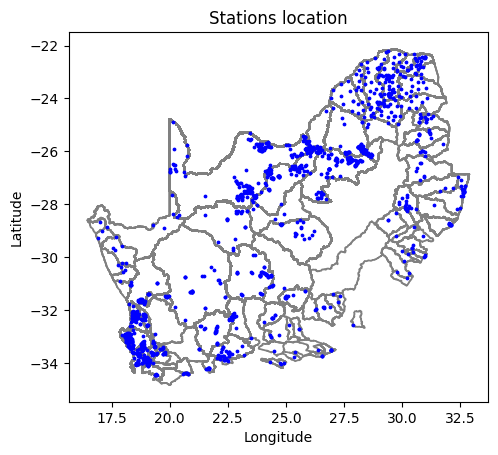

In [10]:
# Plot the polygons
stations_by_polygon.plot(ax=plt.gca(), facecolor='none', edgecolor='grey', linewidth=1.25, label='Polygons')

# Create a scatter plot of the points
plt.scatter(stations_by_polygon['Longitude'], stations_by_polygon['Latitude'], color='blue', label='Stations', s=3)

# Set figure title and labels
plt.title('Stations location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Specify the output file path and name
fNout = f'{path_out}/{dir_out}/catchments_with_stations.shp'
# Export the GeoDataFrame to a shapefile
stations_by_polygon.to_file(fNout)

plt.savefig(f'{path_out}/{dir_out}/stations_location.png')